In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import random
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Resources/SpotifyDataSet.csv')
df.head()

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [4]:
df.describe()

Unnamed: 0     popularity   duration_ms   danceability  \
count  114000.000000  114000.000000  1.140000e+05  114000.000000   
mean    56999.500000      33.238535  2.280292e+05       0.566800   
std     32909.109681      22.305078  1.072977e+05       0.173542   
min         0.000000       0.000000  0.000000e+00       0.000000   
25%     28499.750000      17.000000  1.740660e+05       0.456000   
50%     56999.500000      35.000000  2.129060e+05       0.580000   
75%     85499.250000      50.000000  2.615060e+05       0.695000   
max    113999.000000     100.000000  5.237295e+06       0.985000   

              energy            key       loudness           mode  \
count  114000.000000  114000.000000  114000.000000  114000.000000   
mean        0.641383       5.309140      -8.258960       0.637553   
std         0.251529       3.559987       5.029337       0.480709   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.472000       2.000000     -10.013000       0.000000   
50%         0.685000       5.000000      -7.004000       1.000000   
75%         0.854000       8.000000      -5.003000       1.000000   
max         1.000000      11.000000       4.532000       1.000000   

         speechiness   acousticness  instrumentalness       liveness  \
count  114000.000000  114000.000000     114000.000000  114000.000000   
mean        0.084652       0.314910          0.156050       0.213553   
std         0.105732       0.332523          0.309555       0.190378   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.035900       0.016900          0.000000       0.098000   
50%         0.048900       0.169000          0.000042       0.132000   
75%         0.084500       0.598000          0.049000       0.273000   
max         0.965000       0.996000          1.000000       1.000000   

             valence          tempo  time_signature  
count  114000.000000  114000.000000   114000.000000  
mean        0.474068     122.147837        3.904035  
std         0.259261      29.978197        0.432621  
min         0.000000       0.000000        0.000000  
25%         0.260000      99.218750        4.000000  
50%         0.464000     122.017000        4.000000  
75%         0.683000     140.071000        4.000000  
max         0.995000     243.372000        5.000000

In [5]:
df.dropna()

Unnamed: 0                track_id                 artists  \
0                0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1                1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2                2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3                3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4                4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
...            ...                     ...                     ...   
113995      113995  2C3TZjDRiAzdyViavDJ217           Rainy Lullaby   
113996      113996  1hIz5L4IB9hN3WRYPOCGPw           Rainy Lullaby   
113997      113997  6x8ZfSoqDjuNa5SVP5QjvX           Cesária Evora   
113998      113998  2e6sXL2bYv4bSz6VTdnfLs        Michael W. Smith   
113999      113999  2hETkH7cOfqmz3LqZDHZf5           Cesária Evora   

                                               album_name  \
0                                                  Comedy   
1                                        Ghost (Acoustic)   
2                                          To Begin Again   
3       Crazy Rich Asians (Original Motion Picture Sou...   
4                                                 Hold On   
...                                                   ...   
113995  #mindfulness - Soft Rain for Mindful Meditatio...   
113996  #mindfulness - Soft Rain for Mindful Meditatio...   
113997                                            Best Of   
113998                                  Change Your World   
113999                                     Miss Perfumado   

                        track_name  popularity  duration_ms  explicit  \
0                           Comedy          73       230666     False   
1                 Ghost - Acoustic          55       149610     False   
2                   To Begin Again          57       210826     False   
3       Can't Help Falling In Love          71       201933     False   
4                          Hold On          82       198853     False   
...                            ...         ...          ...       ...   
113995         Sleep My Little Boy          21       384999     False   
113996            Water Into Light          22       385000     False   
113997              Miss Perfumado          22       271466     False   
113998                     Friends          41       283893     False   
113999                   Barbincor          22       241826     False   

        danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0              0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1              0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2              0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3              0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4              0.618  0.4430  ...    -9.681     1       0.0526        0.4690   
...              ...     ...  ...       ...   ...          ...           ...   
113995         0.172  0.2350  ...   -16.393     1       0.0422        0.6400   
113996         0.174  0.1170  ...   -18.318     0       0.0401        0.9940   
113997         0.629  0.3290  ...   -10.895     0       0.0420        0.8670   
113998         0.587  0.5060  ...   -10.889     1       0.0297        0.3810   
113999         0.526  0.4870  ...   -10.204     0       0.0725        0.6810   

        instrumentalness  liveness  valence    tempo  time_signature  \
0               0.000001    0.3580   0.7150   87.917               4   
1               0.000006    0.1010   0.2670   77.489               4   
2               0.000000    0.1170   0.1200   76.332               4   
3               0.000071    0.1320   0.1430  181.740               3   
4               0.000000    0.0829   0.1670  119.949               4   
...                  ...       ...      ...      ...             ...   
113995          0.928000    0.0863   0.0339  125.995               5   
113996          0.97

In [6]:
df.describe()

Unnamed: 0     popularity   duration_ms   danceability  \
count  114000.000000  114000.000000  1.140000e+05  114000.000000   
mean    56999.500000      33.238535  2.280292e+05       0.566800   
std     32909.109681      22.305078  1.072977e+05       0.173542   
min         0.000000       0.000000  0.000000e+00       0.000000   
25%     28499.750000      17.000000  1.740660e+05       0.456000   
50%     56999.500000      35.000000  2.129060e+05       0.580000   
75%     85499.250000      50.000000  2.615060e+05       0.695000   
max    113999.000000     100.000000  5.237295e+06       0.985000   

              energy            key       loudness           mode  \
count  114000.000000  114000.000000  114000.000000  114000.000000   
mean        0.641383       5.309140      -8.258960       0.637553   
std         0.251529       3.559987       5.029337       0.480709   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.472000       2.000000     -10.013000       0.000000   
50%         0.685000       5.000000      -7.004000       1.000000   
75%         0.854000       8.000000      -5.003000       1.000000   
max         1.000000      11.000000       4.532000       1.000000   

         speechiness   acousticness  instrumentalness       liveness  \
count  114000.000000  114000.000000     114000.000000  114000.000000   
mean        0.084652       0.314910          0.156050       0.213553   
std         0.105732       0.332523          0.309555       0.190378   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.035900       0.016900          0.000000       0.098000   
50%         0.048900       0.169000          0.000042       0.132000   
75%         0.084500       0.598000          0.049000       0.273000   
max         0.965000       0.996000          1.000000       1.000000   

             valence          tempo  time_signature  
count  114000.000000  114000.000000   114000.000000  
mean        0.474068     122.147837        3.904035  
std         0.259261      29.978197        0.432621  
min         0.000000       0.000000        0.000000  
25%         0.260000      99.218750        4.000000  
50%         0.464000     122.017000        4.000000  
75%         0.683000     140.071000        4.000000  
max         0.995000     243.372000        5.000000

In [7]:
df["artists"].value_counts()

The Beatles                                                                279
George Jones                                                               271
Stevie Wonder                                                              236
Linkin Park                                                                224
Ella Fitzgerald                                                            222
                                                                          ... 
Lucas Estrada;Wahlstedt;AMAYA                                                1
Dimitri Vegas & Like Mike;Vini Vici;Liquid Soul                              1
Stephen Sondheim;Eddie Cooper;Steven Pasquale;Ethan Slater;Rob Morrison      1
Carl Craig;Jerome Sydenham                                                   1
Dagda                                                                        1
Name: artists, Length: 31437, dtype: int64

In [8]:
df["track_genre"].value_counts()

alt-rock       1000
alternative    1000
honky-tonk     1000
study          1000
guitar         1000
               ... 
spanish        1000
mpb            1000
reggae         1000
reggaeton      1000
acoustic       1000
Name: track_genre, Length: 114, dtype: int64

In [9]:
popular_tracks = df.groupby('track_genre')['popularity'].max()
popular_tracks.head(25)

track_genre
acoustic           82
afrobeat           75
alt-rock           93
alternative        93
ambient            84
anime              83
black-metal        58
bluegrass          69
blues              84
brazil             82
breakbeat          66
british            87
cantopop           72
chicago-house      78
children           77
chill              93
classical          79
club               85
comedy             75
country            89
dance             100
dancehall          83
death-metal        73
deep-house         90
detroit-techno     58
Name: popularity, dtype: int64

In [10]:
popular_tracks2 = df.groupby('track_genre')['popularity'].sum()
popular_tracks2.head(25)

track_genre
acoustic          42483
afrobeat          24399
alt-rock          33943
alternative       24337
ambient           44191
anime             48772
black-metal       22449
bluegrass         25676
blues             31188
brazil            44670
breakbeat         20123
british           43802
cantopop          34739
chicago-house     12339
children          35047
chill             53651
classical         13055
club              33338
comedy            24628
country           17028
dance             22690
dancehall         33467
death-metal       32169
deep-house        44808
detroit-techno    11174
Name: popularity, dtype: int64

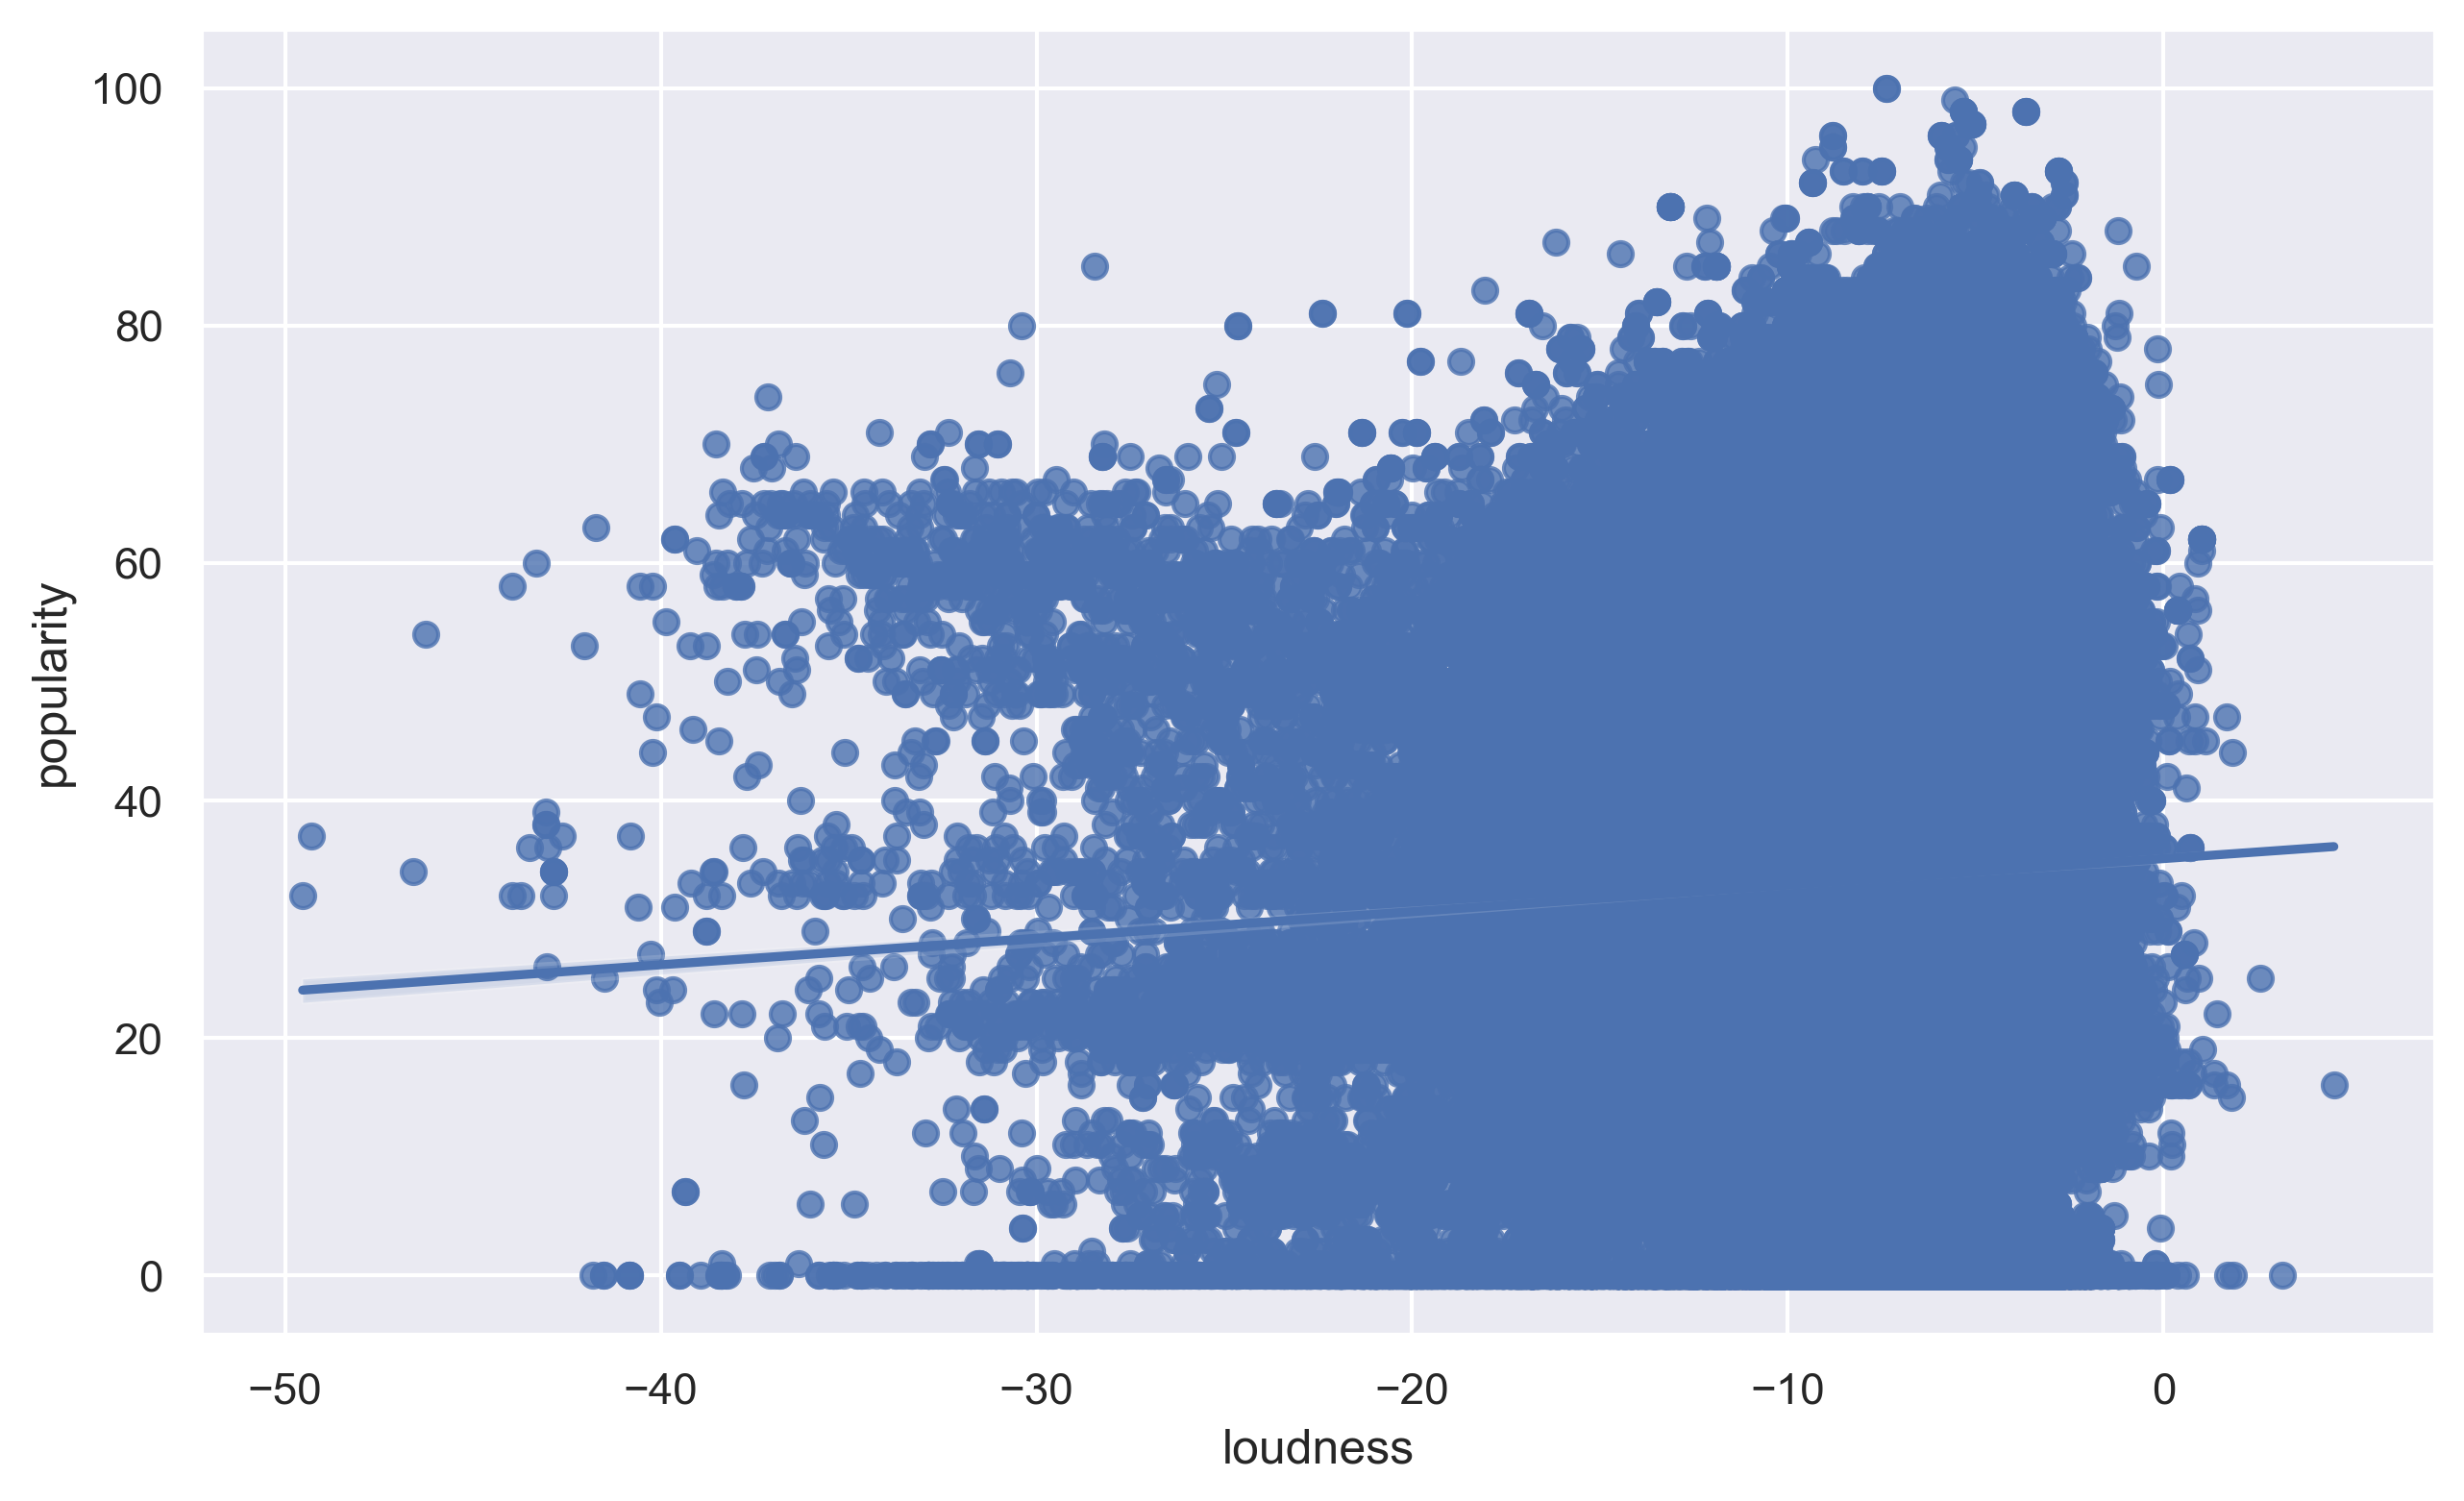

In [11]:
sns.set()
plt.figure(figsize=(10, 6), dpi=300)
sns.regplot(x='loudness', y='popularity', data=df)

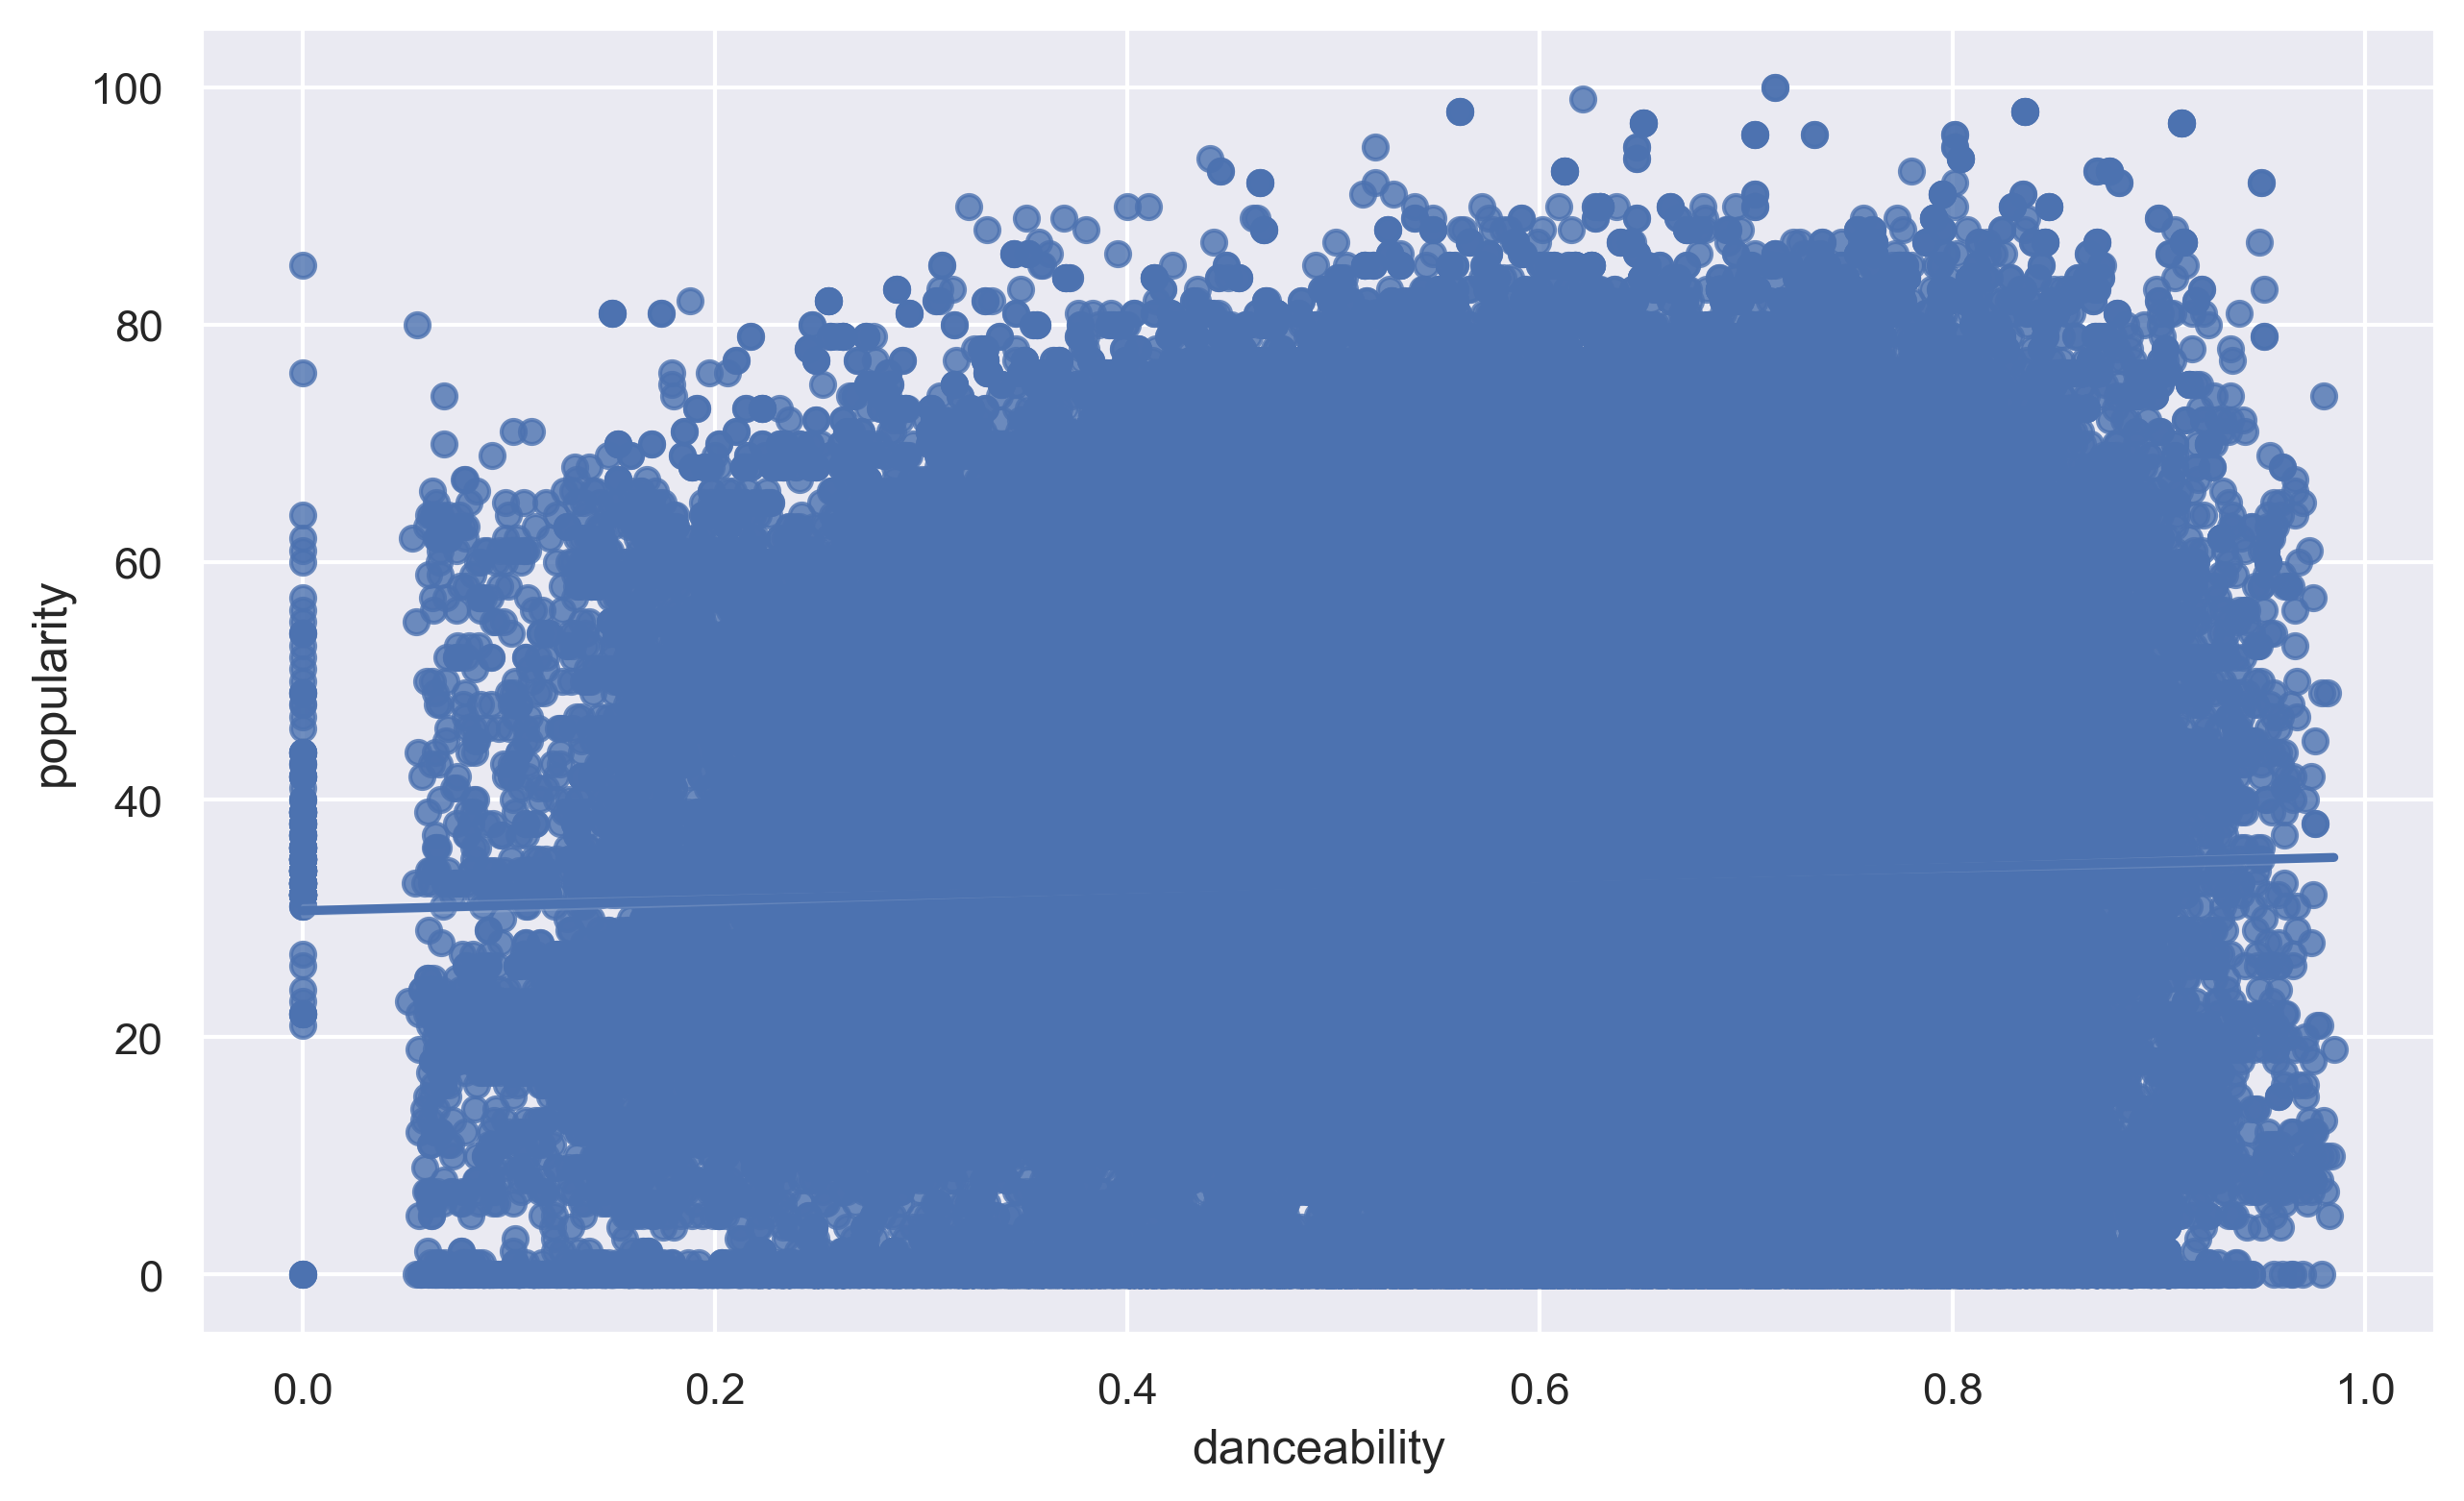

In [12]:
sns.set()
plt.figure(figsize=(10, 6), dpi=300)
sns.regplot(x='danceability', y='popularity', data=df)

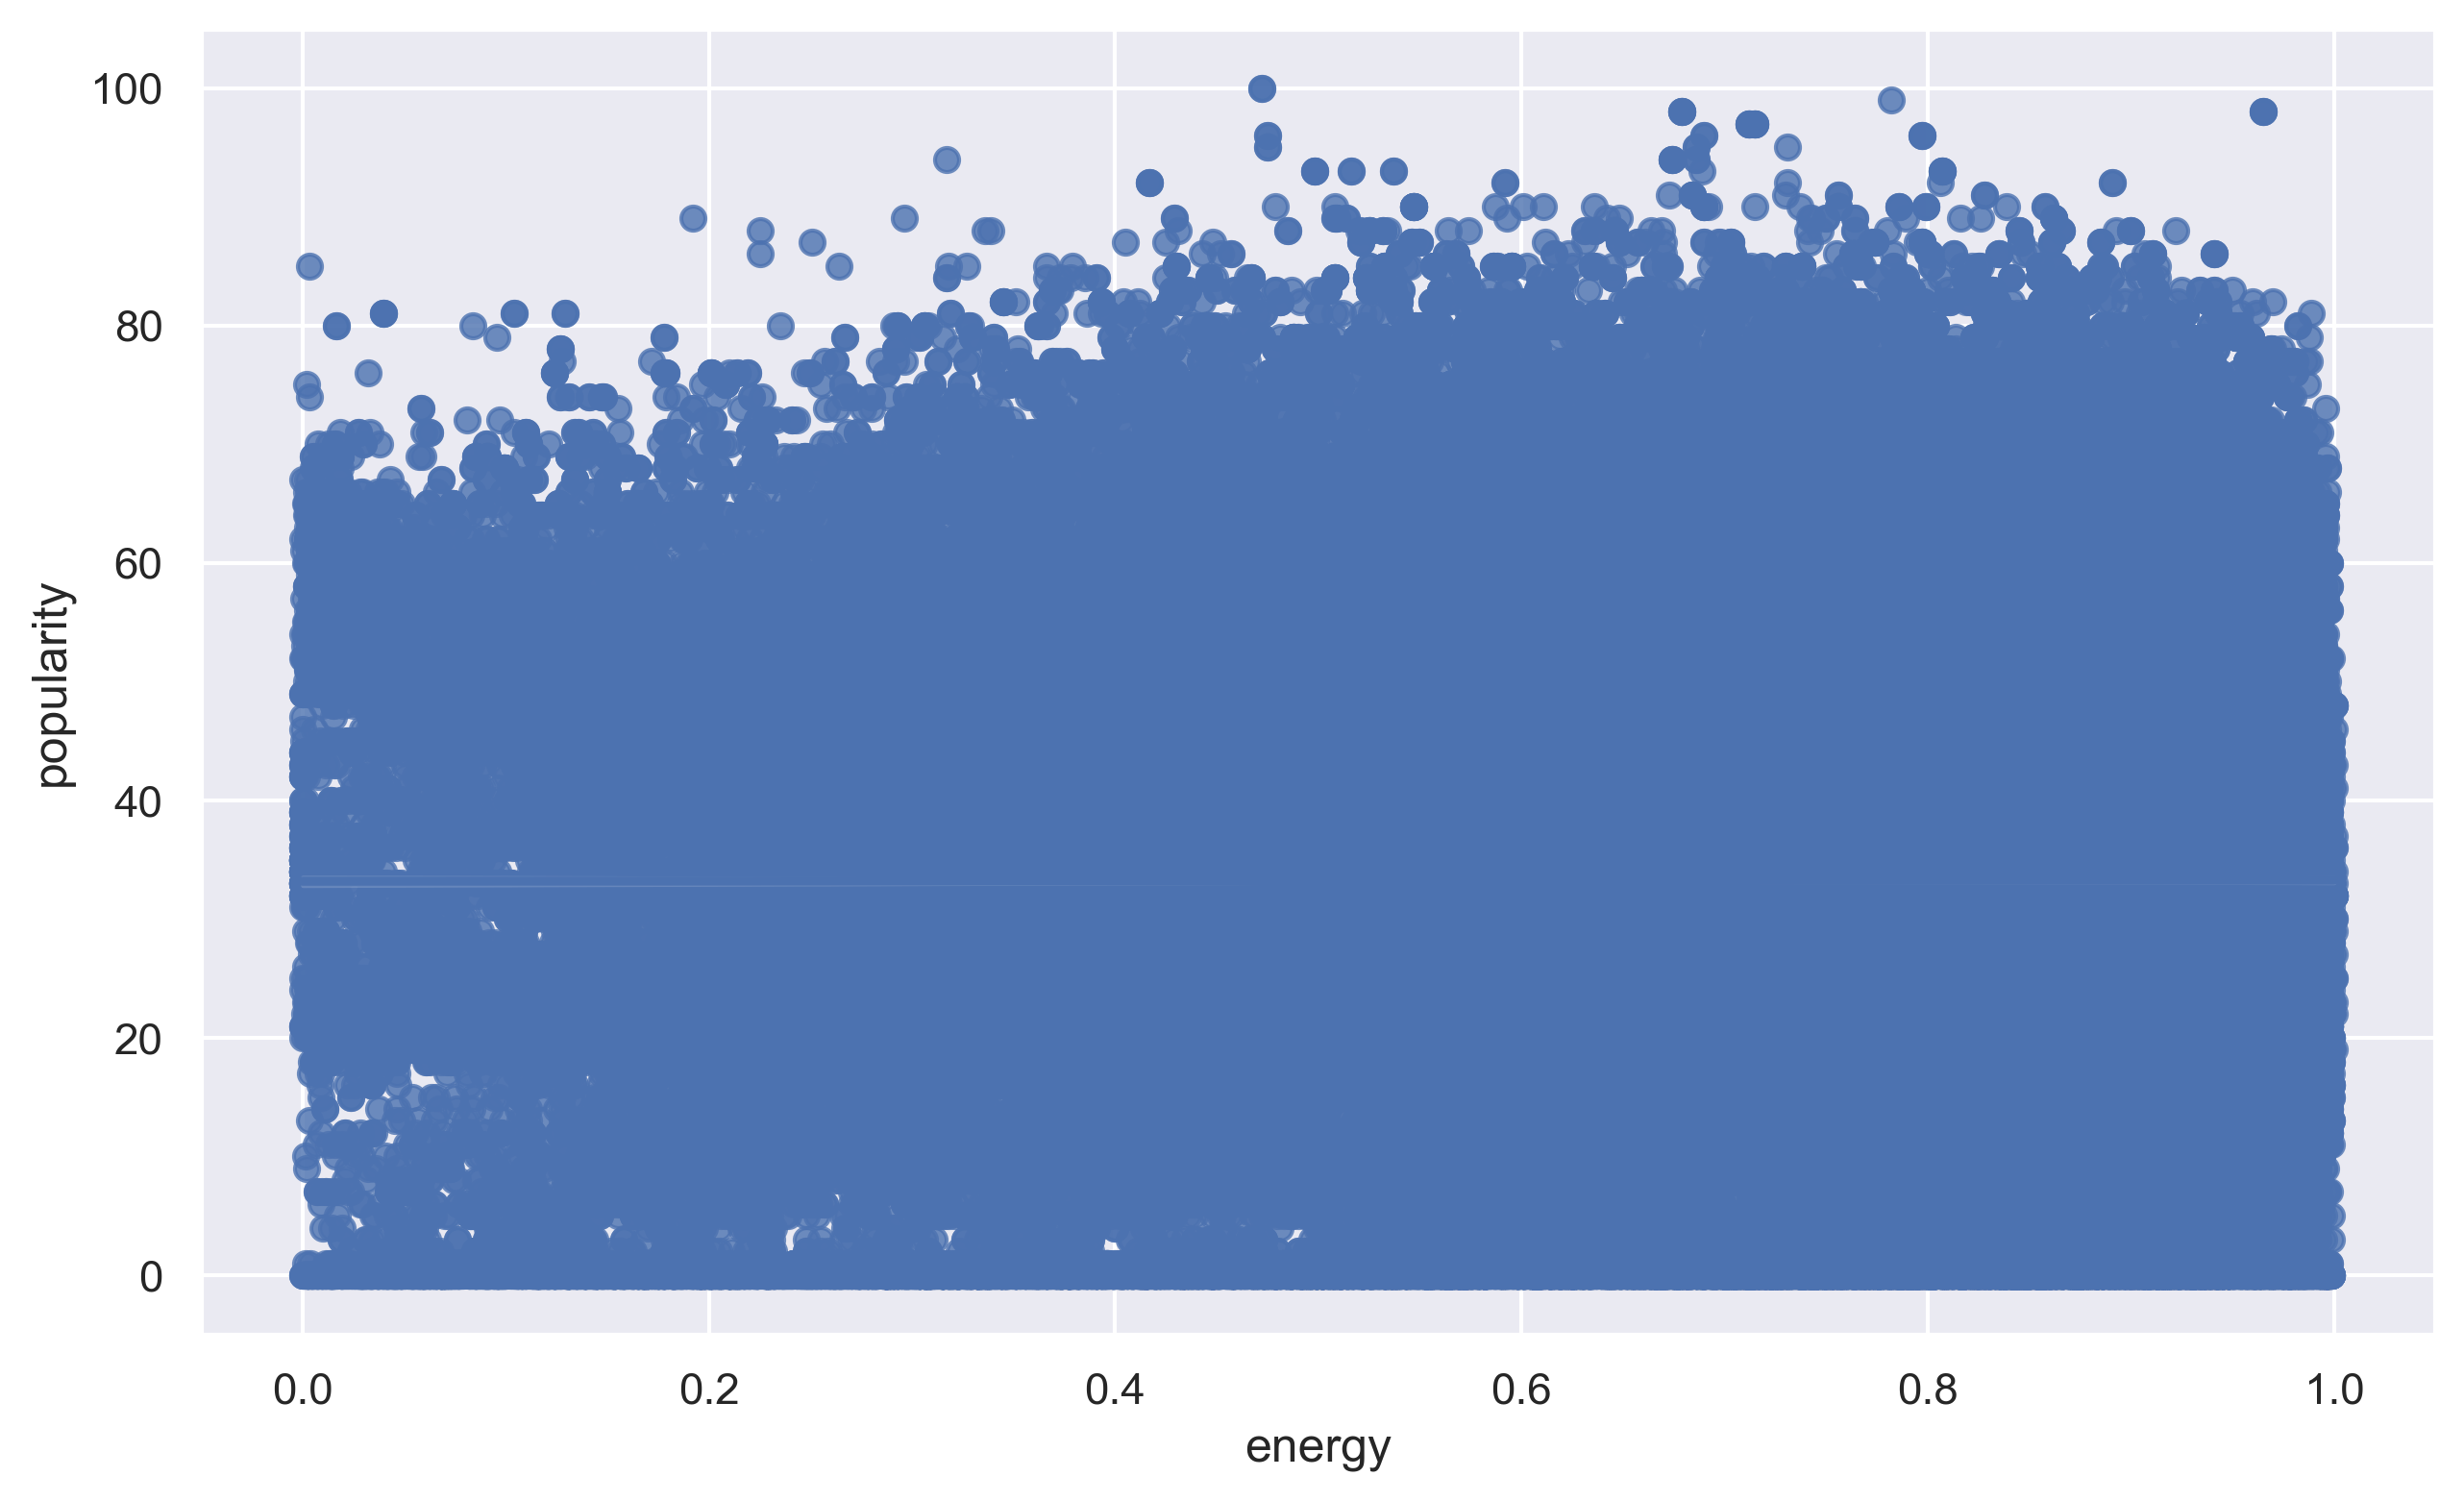

In [13]:
sns.set()
plt.figure(figsize=(10, 6), dpi=300)
sns.regplot(x='energy', y='popularity', data=df)

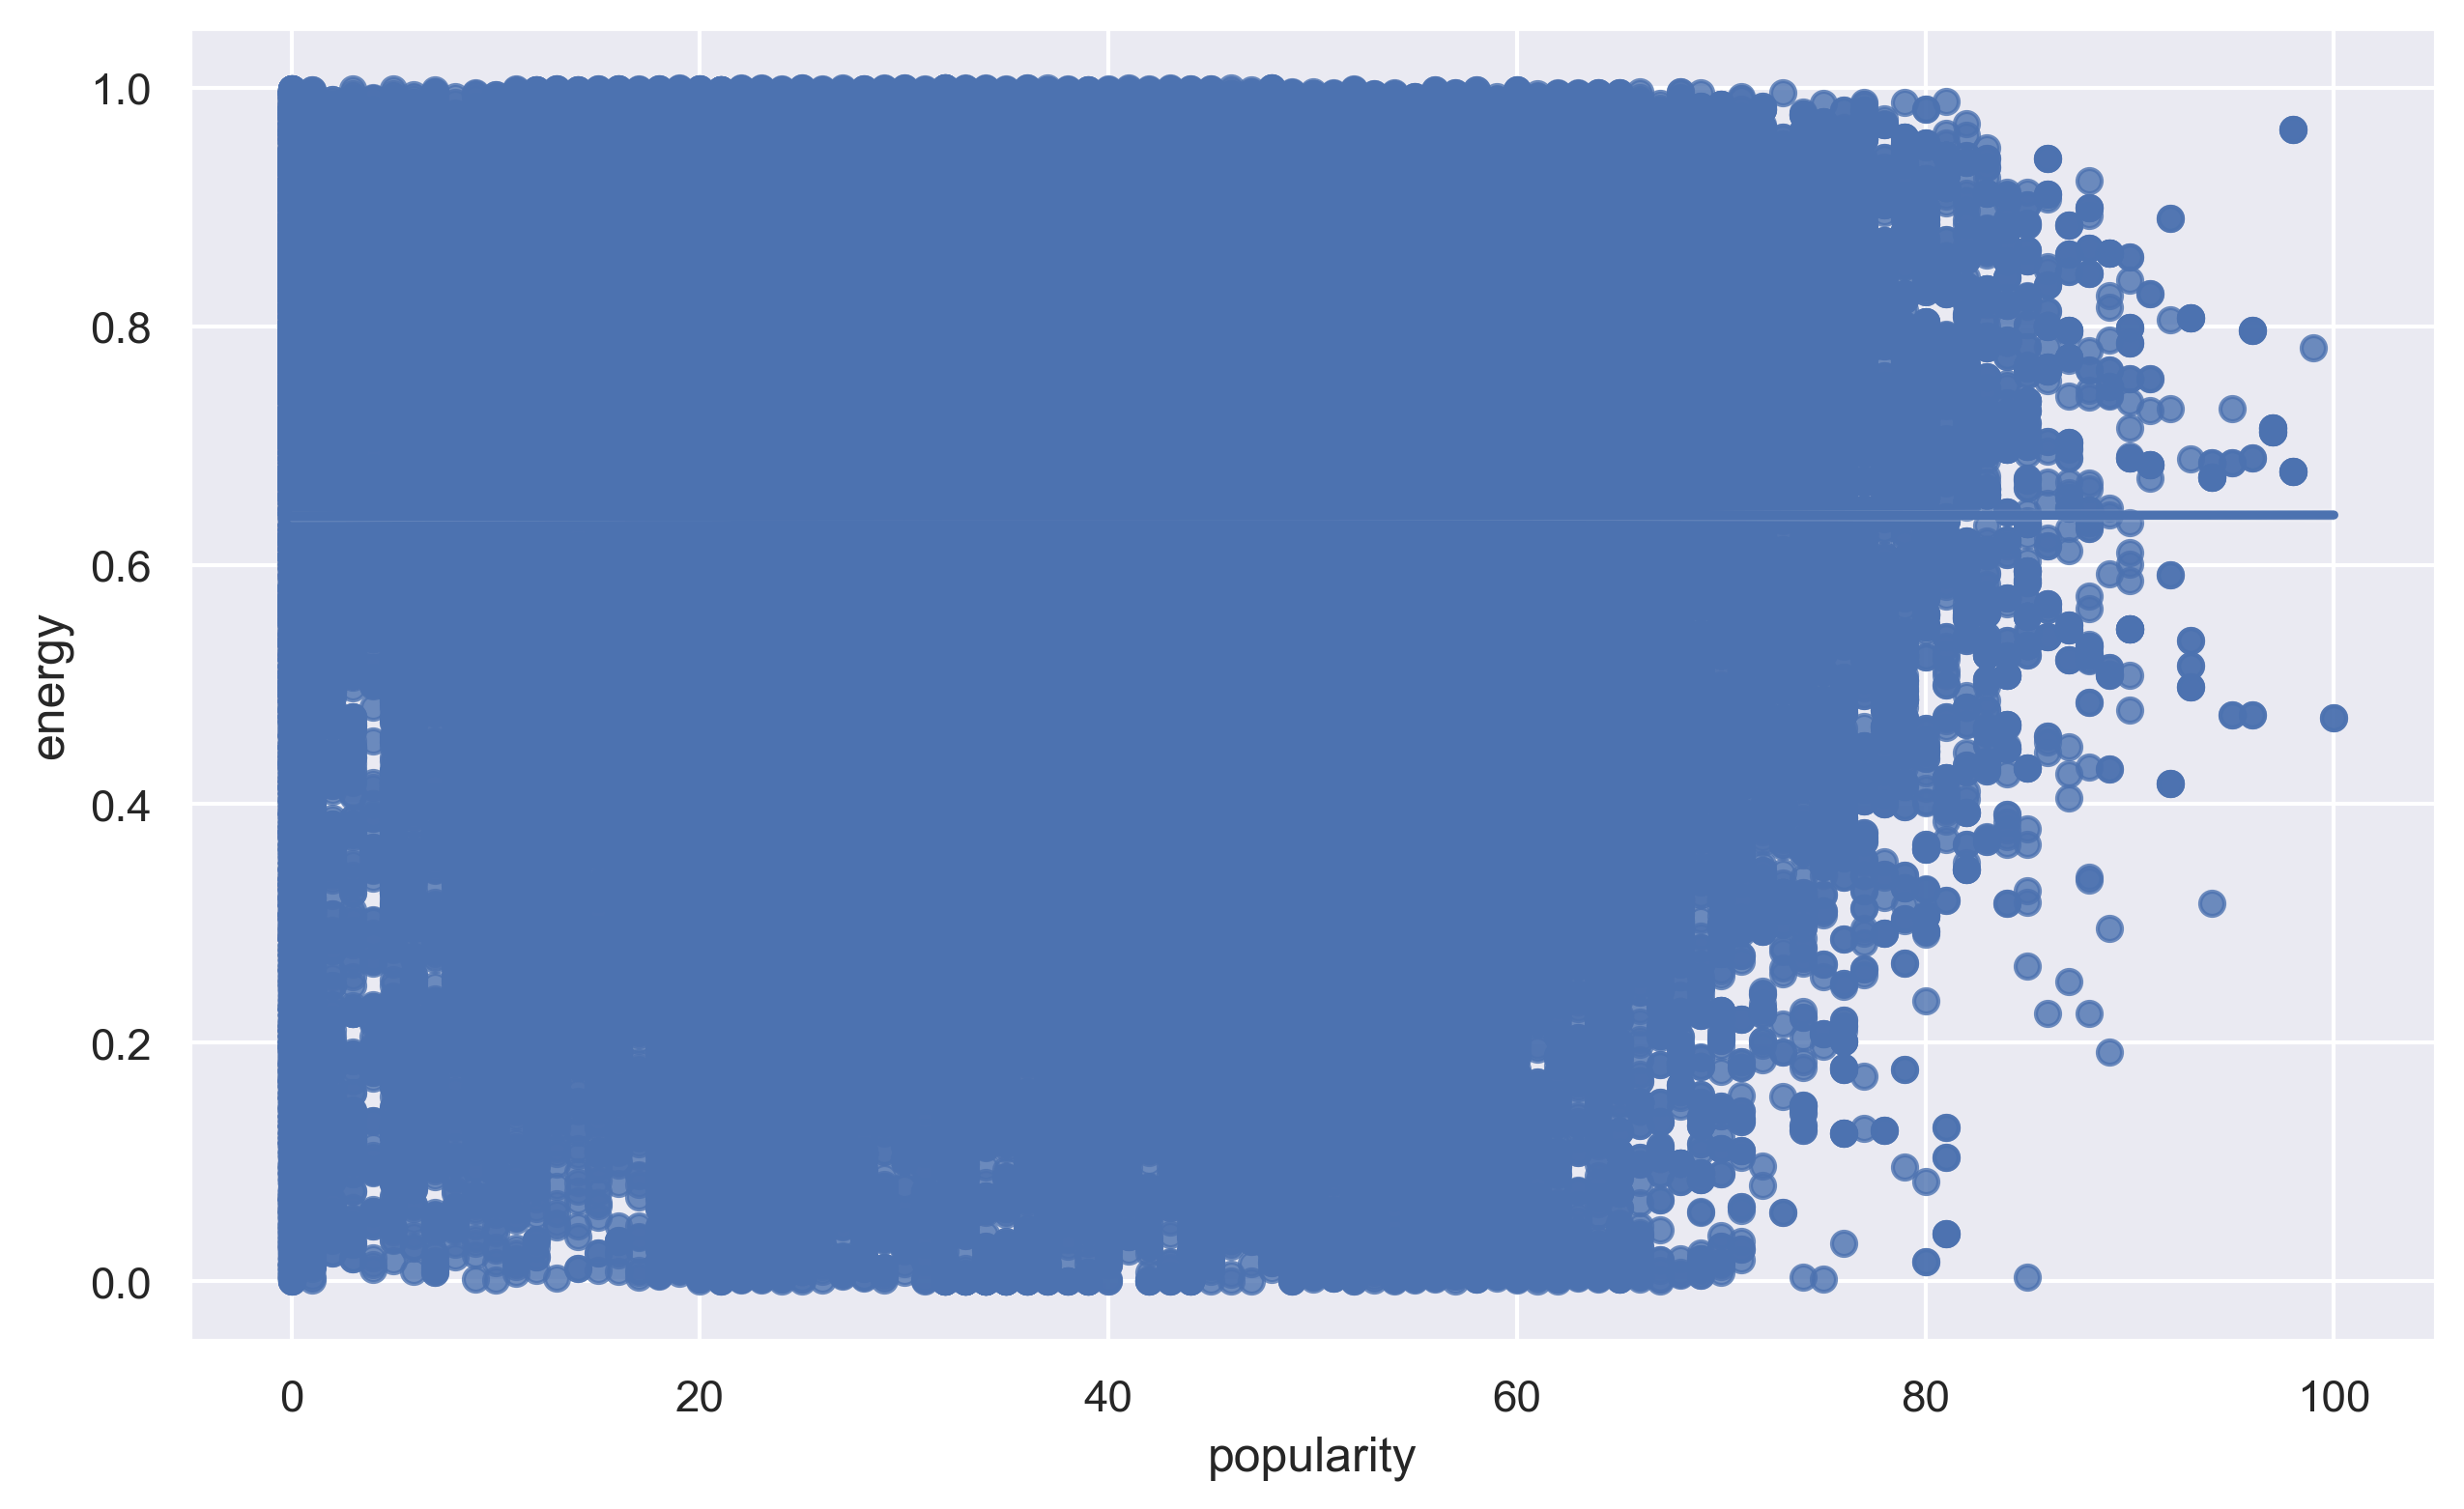

In [14]:
sns.set()
plt.figure(figsize=(10, 6), dpi=300)
sns.regplot(x='popularity', y='energy', data=df)

In [15]:
df = df.drop_duplicates(
  subset = ['artists', 'track_name'],
  keep = 'first').reset_index(drop = True)

In [16]:
px.imshow(df.corr())

In [17]:
top_genres = df.groupby('track_genre').mean().sort_values('popularity', ascending=False)
px.bar(top_genres, x=top_genres.index, y='popularity')

In [18]:
#Top Ten Genres from above
genres = [
    'k-pop',
    'metal',
    'chill',
    'sad',
    'grunge',
    'indian',
    'piano',
    'indie-pop',
    'house',
    'deep-house',
]

In [19]:
fig = make_subplots(rows=4, cols=4, vertical_spacing=0.16, subplot_titles = genres)
row=1
col=1

for genre in genres:
    top_artists = df.query('track_genre == @genre')
    top_artists = top_artists.groupby(by='artists').mean().sort_values('popularity', ascending=False)
    top_artists = top_artists.loc[~top_artists.index.str.contains(';')]
    top_artists = top_artists.head(10)
    
    fig.add_trace(
    go.Bar(name=genre, x=top_artists.index, y=top_artists['popularity']),
    row=row, col=col)
    
    col += 1
    if (col == 5):
        col = 1
        row += 1
    
    fig.update_layout(height=2000, width=1000, title_text="10 Most Popular Artists in Specific Genres, by Average Popularity")
    
fig.show()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [21]:
y = df['popularity']
X = df[['energy', 'danceability', 'duration_ms', 'tempo']]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

In [23]:
new_df =  pd.DataFrame(lr.coef_, X.columns, columns=['Coefficient'])
new_df

Coefficient
energy          -1.888018
danceability    10.316388
duration_ms     -0.000008
tempo            0.002189

In [24]:
df_model = pd.DataFrame({'Actual': y_test, 'Predicted': pred})
df_model

Actual  Predicted
17651      75  37.222220
60084      59  34.713041
11789       8  36.125958
70353      36  34.764002
7538       51  32.668333
...       ...        ...
3479       27  32.387134
18539      31  32.876675
7458        0  35.025191
63596      25  35.427175
3672       43  33.229262

[65076 rows x 2 columns]

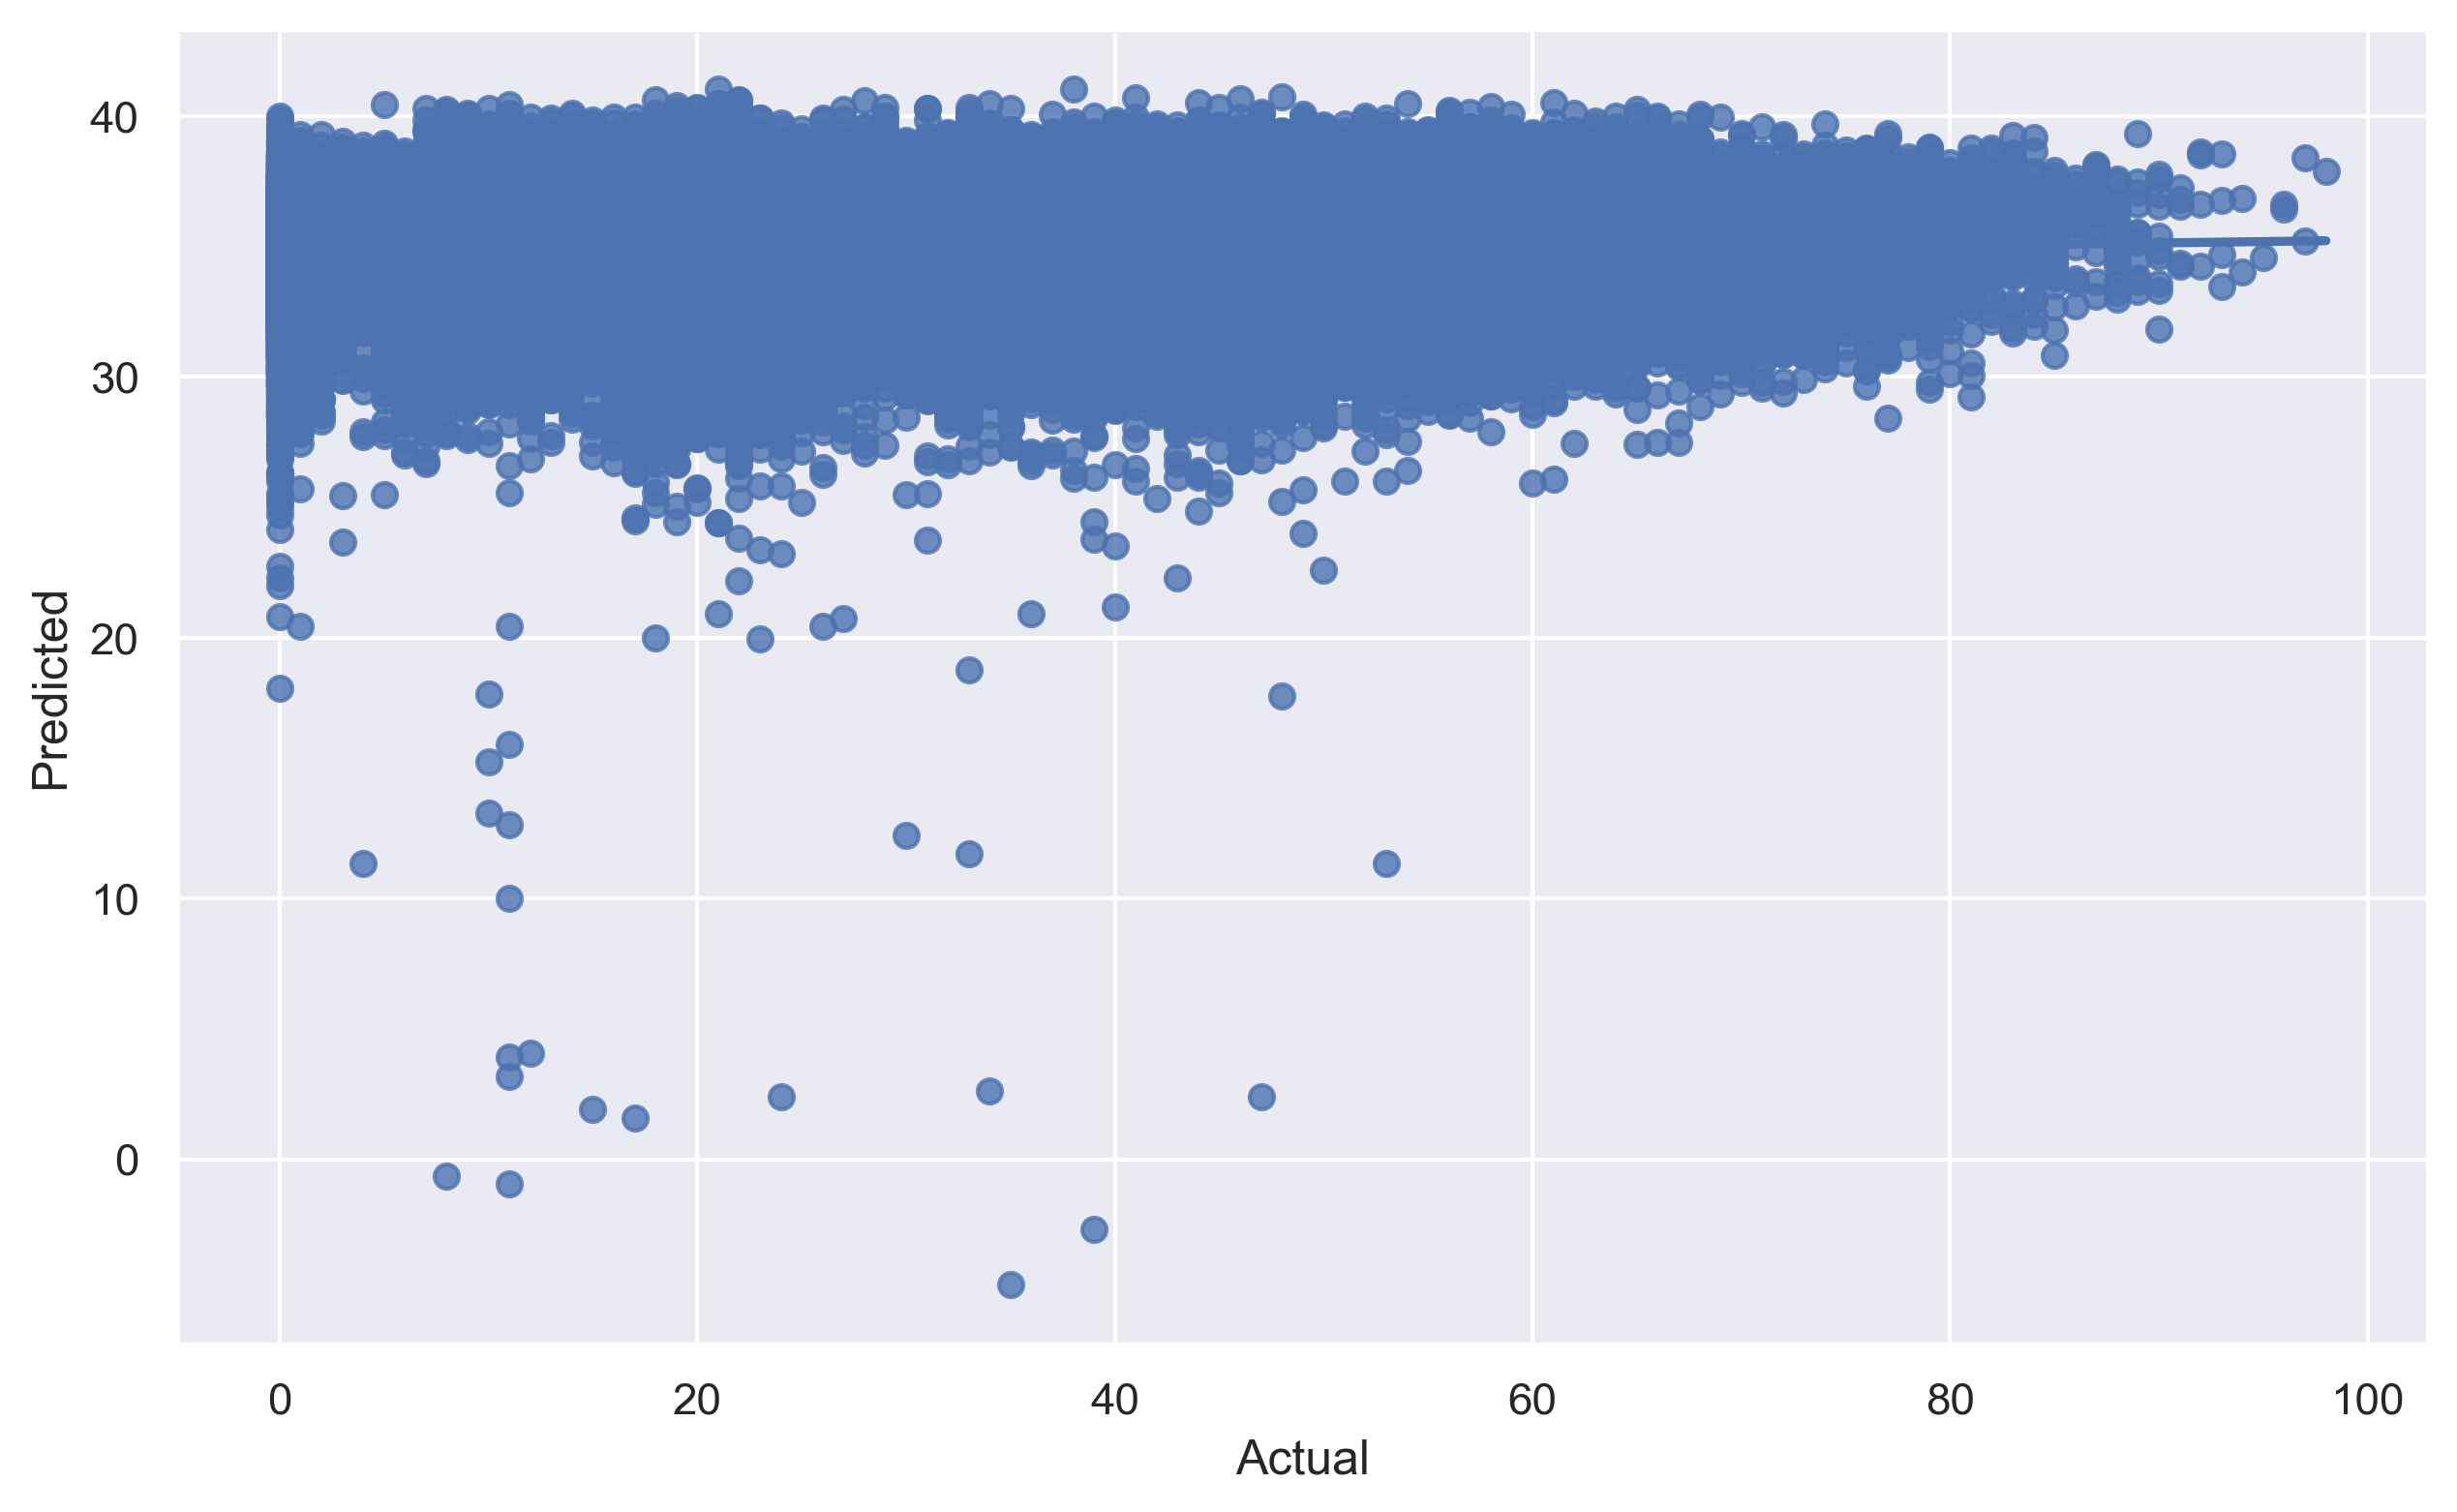

In [25]:
sns.set()
plt.figure(figsize=(10, 6), dpi=300)
sns.regplot(x='Actual', y='Predicted', data=df_model)

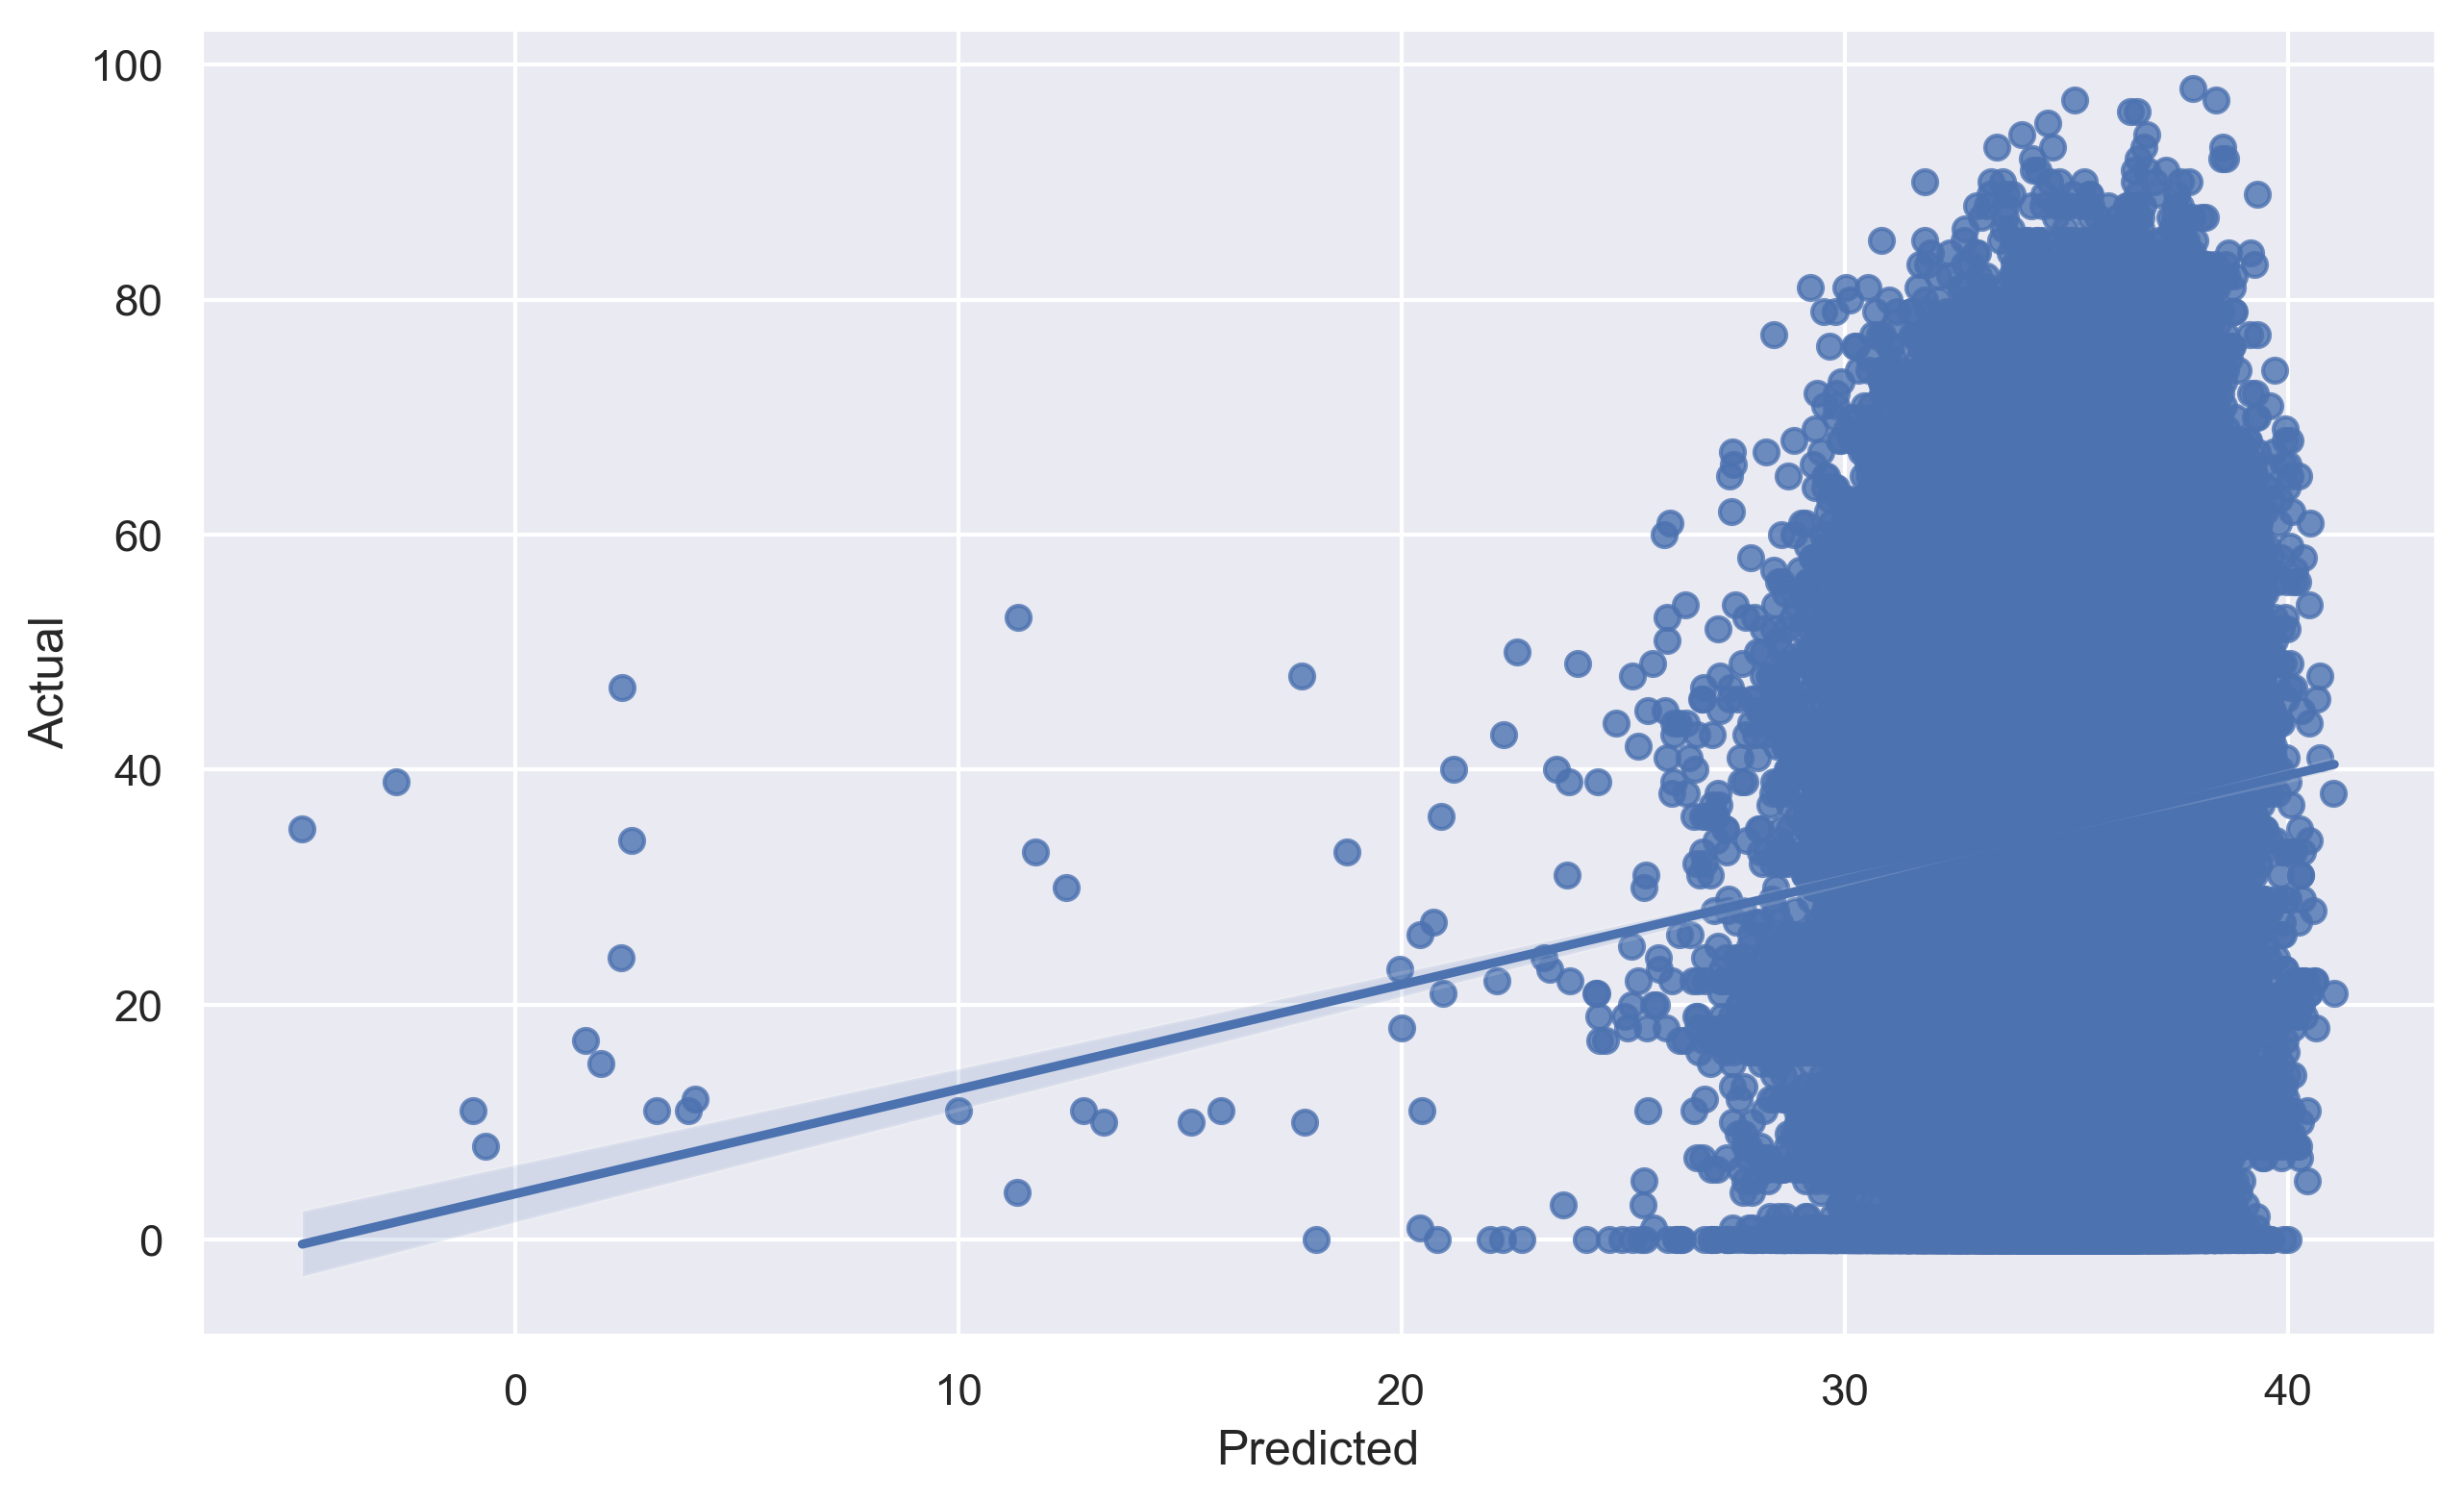

In [26]:
sns.set()
plt.figure(figsize=(10, 6), dpi=300)
sns.regplot(x='Predicted', y='Actual', data=df_model)

In [27]:
df.copy(deep=True)

Unnamed: 0                track_id                 artists  \
0               0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1               1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2               2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3               3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4               4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
...           ...                     ...                     ...   
81339      113995  2C3TZjDRiAzdyViavDJ217           Rainy Lullaby   
81340      113996  1hIz5L4IB9hN3WRYPOCGPw           Rainy Lullaby   
81341      113997  6x8ZfSoqDjuNa5SVP5QjvX           Cesária Evora   
81342      113998  2e6sXL2bYv4bSz6VTdnfLs        Michael W. Smith   
81343      113999  2hETkH7cOfqmz3LqZDHZf5           Cesária Evora   

                                              album_name  \
0                                                 Comedy   
1                                       Ghost (Acoustic)   
2                                         To Begin Again   
3      Crazy Rich Asians (Original Motion Picture Sou...   
4                                                Hold On   
...                                                  ...   
81339  #mindfulness - Soft Rain for Mindful Meditatio...   
81340  #mindfulness - Soft Rain for Mindful Meditatio...   
81341                                            Best Of   
81342                                  Change Your World   
81343                                     Miss Perfumado   

                       track_name  popularity  duration_ms  explicit  \
0                          Comedy          73       230666     False   
1                Ghost - Acoustic          55       149610     False   
2                  To Begin Again          57       210826     False   
3      Can't Help Falling In Love          71       201933     False   
4                         Hold On          82       198853     False   
...                           ...         ...          ...       ...   
81339         Sleep My Little Boy          21       384999     False   
81340            Water Into Light          22       385000     False   
81341              Miss Perfumado          22       271466     False   
81342                     Friends          41       283893     False   
81343                   Barbincor          22       241826     False   

       danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0             0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1             0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2             0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3             0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4             0.618  0.4430  ...    -9.681     1       0.0526        0.4690   
...             ...     ...  ...       ...   ...          ...           ...   
81339         0.172  0.2350  ...   -16.393     1       0.0422        0.6400   
81340         0.174  0.1170  ...   -18.318     0       0.0401        0.9940   
81341         0.629  0.3290  ...   -10.895     0       0.0420        0.8670   
81342         0.587  0.5060  ...   -10.889     1       0.0297        0.3810   
81343         0.526  0.4870  ...   -10.204     0       0.0725        0.6810   

       instrumentalness  liveness  valence    tempo  time_signature  \
0              0.000001    0.3580   0.7150   87.917               4   
1              0.000006    0.1010   0.2670   77.489               4   
2              0.000000    0.1170   0.1200   76.332               4   
3              0.000071    0.1320   0.1430  181.740               3   
4              0.000000    0.0829   0.1670  119.949               4   
...                 ...       ...      ...      ...             ...   
81339          0.928000    0.0863   0.0339  125.995               5   
81340          0.976000    0.1050   0.0350   85.239               4   
8134

In [28]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [29]:
data1=labelencoder(df.iloc[:,1:])

In [30]:
target=['popularity']
dataY=data1[target]
dataX=data1.drop(target,axis=1)

In [31]:
df_columns = list(dataX.columns)
print(df_columns)

['track_id', 'artists', 'album_name', 'track_name', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


In [32]:
m=len(dataX)
print(m)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

trainX=dataX.iloc[M[0:(m//4)*3]]
trainY=dataY.iloc[M[0:(m//4)*3]]
testX=dataX.iloc[M[(m//4)*3:]]
testY=dataY.iloc[M[(m//4)*3:]]

81344


In [33]:
train_df=trainX
test_df=testX


In [34]:
train_df.columns=df_columns
test_df.columns=df_columns

In [35]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [36]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [37]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [38]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

  0%|                                                    | 0/1 [00:00<?, ?it/s]

createcreate_numeric_feature  0.007[s]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 166.91it/s]

createcreate_numeric_feature  0.003[s]


In [39]:
def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [40]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [41]:
y = trainY
ydf=pd.DataFrame(y)
ydf

popularity
36907          21
15234          29
70029          47
47259          19
46802          24
...           ...
38659           0
59558          25
35384          64
31109          50
68864          29

[61008 rows x 1 columns]

[500]	valid_0's rmse: 14.333
[1000]	valid_0's rmse: 14.1276
[1500]	valid_0's rmse: 14.0702
fit fold=0  5.143[s]
Fold 0 RMSLE: 14.0689

[500]	valid_0's rmse: 14.3986
[1000]	valid_0's rmse: 14.2146
[1500]	valid_0's rmse: 14.1627
fit fold=1  5.026[s]
Fold 1 RMSLE: 14.1551

[500]	valid_0's rmse: 14.1952
[1000]	valid_0's rmse: 13.9757
fit fold=2  3.821[s]
Fold 2 RMSLE: 13.9567

[500]	valid_0's rmse: 14.1612
[1000]	valid_0's rmse: 13.9835
fit fold=3  4.271[s]
Fold 3 RMSLE: 13.9328

[500]	valid_0's rmse: 14.3961
[1000]	valid_0's rmse: 14.1937
fit fold=4  4.454[s]
Fold 4 RMSLE: 14.1430

--------------------------------------------------
FINISHED | Whole RMSLE: 14.0516


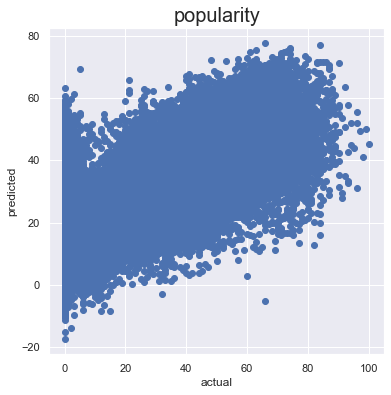

In [42]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_ylabel('predicted',fontsize=12)
    ax.set_xlabel('actual',fontsize=12)
    ax.scatter(y,oof)

In [43]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

[500]	valid_0's rmse: 14.333
[1000]	valid_0's rmse: 14.1276
[1500]	valid_0's rmse: 14.0702
fit fold=0  5.192[s]
Fold 0 RMSLE: 14.0689

[500]	valid_0's rmse: 14.3986
[1000]	valid_0's rmse: 14.2146
[1500]	valid_0's rmse: 14.1627
fit fold=1  4.839[s]
Fold 1 RMSLE: 14.1551

[500]	valid_0's rmse: 14.1952
[1000]	valid_0's rmse: 13.9757
fit fold=2  3.956[s]
Fold 2 RMSLE: 13.9567

[500]	valid_0's rmse: 14.1612
[1000]	valid_0's rmse: 13.9835
fit fold=3  4.701[s]
Fold 3 RMSLE: 13.9328

[500]	valid_0's rmse: 14.3961
[1000]	valid_0's rmse: 14.1937
fit fold=4  4.170[s]
Fold 4 RMSLE: 14.1430

--------------------------------------------------
FINISHED | Whole RMSLE: 14.0516


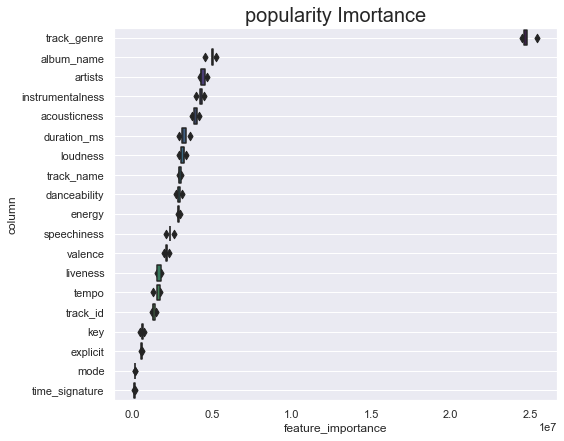

In [44]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

In [45]:
preds=[]
for i in range(5):
    preds += [models[i].predict(test_feat_df.values)/5]
predsT=np.array(preds).T
preds2=[]
for item in predsT:
    value=sum(item)
    preds2+=[value]
print(preds2[0:5])

[12.322597031984268, 45.263509918167976, 44.07692672427684, 19.491046417297316, 40.57807343243831]


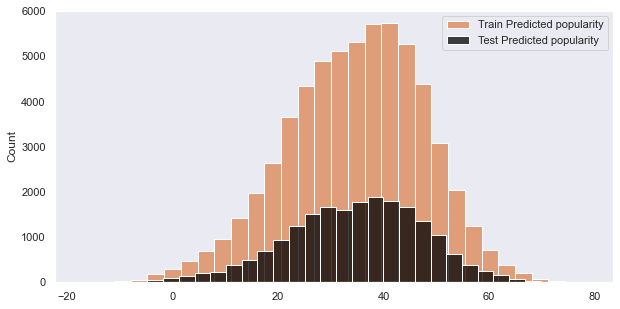

In [46]:
for i in range(1):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(oof, label='Train Predicted '+target[i], ax=ax, color='C1',bins=30)
    sns.histplot(preds2, label='Test Predicted '+target[i], ax=ax, color='black',bins=30)
    ax.legend()
    ax.grid()

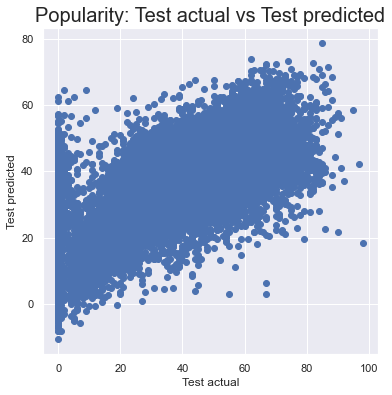

In [47]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title('Popularity: Test actual vs Test predicted',fontsize=20)
ax.set_ylabel('Test predicted',fontsize=12)
ax.set_xlabel('Test actual',fontsize=12)
ax.scatter(testY,preds2)
plt.show()